## Word2Vec Approach

In [135]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, \
    nltk, collections, keras, lightgbm as lgb
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout,Conv1D, GlobalMaxPooling1D, MaxPooling1D, Bidirectional, GRU
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import re,string,unicodedata
from string import punctuation
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU

In [117]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

#remove Stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [118]:
#kudos https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy#LOADING-THE-DATASET
#remove square brackets, URLs and Noise

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

c:\Users\benit\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [119]:
#converting text to format acceptable by gensim

words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [120]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words, window = 5, min_count = 1)


In [121]:
#get w2v_model vocabulary size
w2v_model.wv.vectors.shape


(38071, 100)

In [122]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
#x = sequence.pad_sequences(tokenized_train, maxlen = 20)
sequences = tokenizer.texts_to_sequences(words)
#help from CHTGPT
padded_sequences = pad_sequences(sequences, maxlen=20)
vocab_size = len(tokenizer.word_index) + 1

In [123]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [124]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

### Training Word2Vec model

In [125]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=64 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=16 , recurrent_dropout = 0.3 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.0001), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

c:\Users\benit\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [126]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 20, 100)           3807200   
                                                                 
 bidirectional_21 (Bidirecti  (None, 20, 64)           34048     
 onal)                                                           
                                                                 
 bidirectional_22 (Bidirecti  (None, 20, 32)           7872      
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 20, 1)             33        
                                                                 
Total params: 3,849,153
Trainable params: 3,849,153
Non-trainable params: 0
_________________________________________________________________


In [127]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df.is_sarcastic , test_size = 0.3 , random_state = 0) 
#validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3 , random_state = 0)

In [128]:
#ealry stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


In [129]:
history = model.fit(x_train, y_train, batch_size = 512 , validation_data = (x_val,y_val) , epochs = 200, callbacks=[early_stopping])

Epoch 1/200
28/28 [==============================] - 29s 763ms/step - loss: 0.6813 - acc: 0.5638 - val_loss: 0.6657 - val_acc: 0.5893
Epoch 2/200
28/28 [==============================] - 20s 721ms/step - loss: 0.5746 - acc: 0.7004 - val_loss: 0.5140 - val_acc: 0.7583
Epoch 3/200
28/28 [==============================] - 22s 799ms/step - loss: 0.3020 - acc: 0.8808 - val_loss: 0.4584 - val_acc: 0.7966
Epoch 4/200
28/28 [==============================] - 23s 809ms/step - loss: 0.1372 - acc: 0.9506 - val_loss: 0.5571 - val_acc: 0.7930
Epoch 5/200
28/28 [==============================] - 25s 909ms/step - loss: 0.0645 - acc: 0.9795 - val_loss: 0.7363 - val_acc: 0.7865
Epoch 6/200
28/28 [==============================] - 27s 953ms/step - loss: 0.0373 - acc: 0.9884 - val_loss: 0.8188 - val_acc: 0.7889
Epoch 7/200
28/28 [==============================] - 21s 766ms/step - loss: 0.0242 - acc: 0.9931 - val_loss: 0.9023 - val_acc: 0.7865
Epoch 8/200
28/28 [==============================] - 20s 718ms

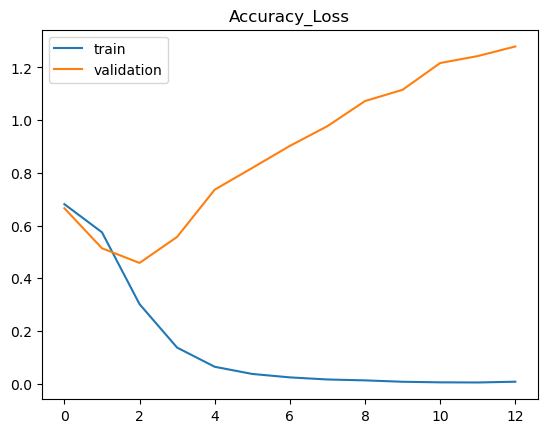

In [130]:
#plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Accuracy_Loss')
plt.legend()
plt.show()


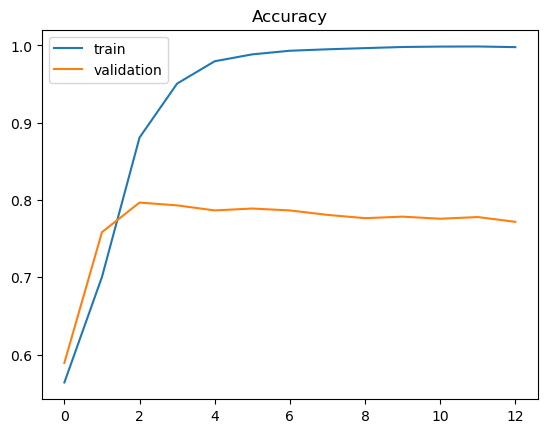

In [131]:
#plot accuracy
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.legend()
plt.show()

In [132]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

439/439 [==============================] - 7s 15ms/step - loss: 0.0016 - acc: 0.9997
Accuracy of the model on Training Data is -  99.97325539588928
269/269 [==============================] - 4s 15ms/step - loss: 1.2841 - acc: 0.7715
Accuracy of the model on Testing Data is -  77.1482765674591


In [134]:
#train naive bayes model
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
print("Accuracy of the model on Training Data is - " , accuracy_score(y_train, nb.predict(x_train))*100,"%")

#test accuracy_score
print("Accuracy of the model on Testing Data is - " , accuracy_score(y_test, y_pred)*100,"%")




Accuracy of the model on Training Data is -  56.88511730728089 %
Accuracy of the model on Testing Data is -  56.650361052876775 %
